In [1]:
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/calibration_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

image = mpimg.imread('test_images/test1.jpg')

def select_yellow_white(image):
    img = np.copy(image)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)

    hsv_copy = np.copy(hsv)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(hsv_copy, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(hsv_copy, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    filtered_img = cv2.bitwise_and(image, image, mask = mask)
    
    return filtered_img
    

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 230), sx_thresh=(20, 100), l_thresh=(200,255)):
    img = np.copy(img)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    #filtered_img = select_yellow_white(image)
    hsv_copy = np.copy(hsv)
    #find yellow and white
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(hsv_copy, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(hsv_copy, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    filtered_img = cv2.bitwise_and(image, image, mask = mask)
    filtered_img = filtered_img[:,:,2]
    yellow = np.zeros_like(h_channel)
    yellow[(filtered_img >= 0) & (filtered_img <= 40)] = 1
    #print("s binary shape:",s_binary.shape)
    #print("filtered_img shape:", filtered_img.shape)
    
    #plt.imshow(yellow)
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary,yellow))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1) | (l_binary == 1) | (yellow == 0)] = 1

    # Plotting thresholded images
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    #ax1.set_title('Stacked thresholds')
    #ax1.imshow(color_binary)

    #ax2.set_title('Combined S channel and gradient thresholds')
    #ax2.imshow(combined_binary, cmap='gray')
    return combined_binary
    


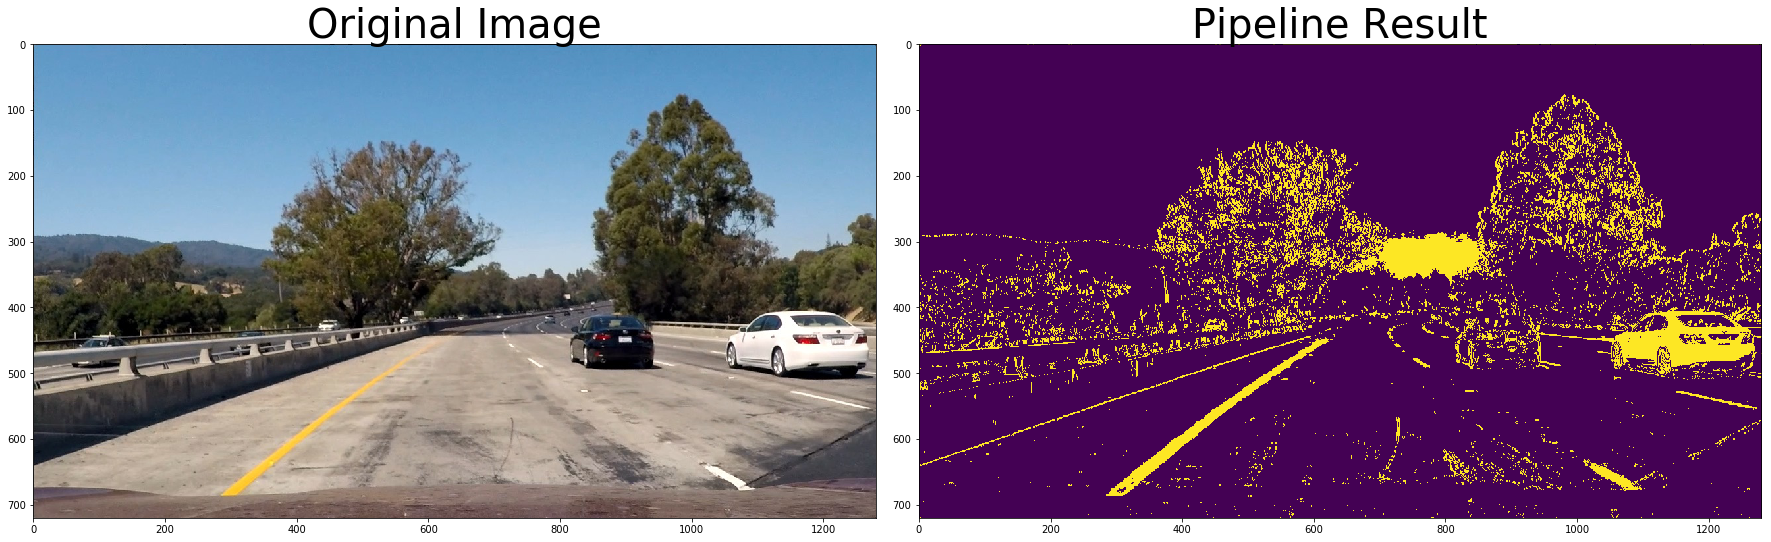

In [2]:
%matplotlib inline

result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



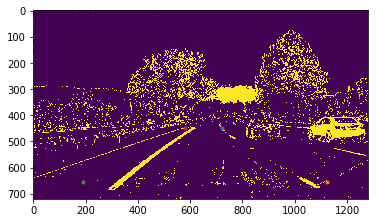

In [3]:
%matplotlib inline

# source image points

plt.imshow(result)
plt.plot(720, 450, '.') #top right
plt.plot(1125,655, '.') #bottom right
plt.plot(190,655,'.') #bottom left
plt.plot(580,450,'.')#top left

In [4]:
# define perspective transform function
def warp(img):
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    #Define calibration box in source and destination coordinates
    img_size = (img.shape[1],img.shape[0])
    
    #Four source coordinates
    src = np.float32(
    [[710,450],[1135,655],[110,655],[560,450]])
    
    #Four desired coordinates
    dst = np.float32(
    [[1135,20],[1135,655],[110,655],[110,20]])
    
    #Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src,dst)
    
    #Could compute the inverse M
    Iver_M = cv2.getPerspectiveTransform(dst,src)
    
    #Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(undist,M,img_size,flags=cv2.INTER_LINEAR)
    
    return warped

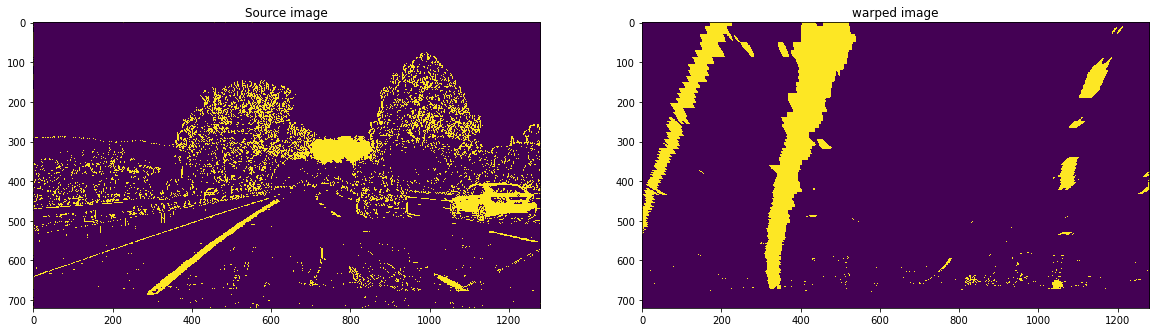

In [5]:
%matplotlib inline

#Get perspective transform
warped_im = warp(result)

#VIsualize undistortion
f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))

ax1.set_title("Source image")
ax1.imshow(result)
ax2.set_title('warped image')
ax2.imshow(warped_im)

warped im shape[0]: 720 and shape[1]: 1280
histogram shape[0]: 1280
leftx base: 341
rightx base: 1058


(720, 0)

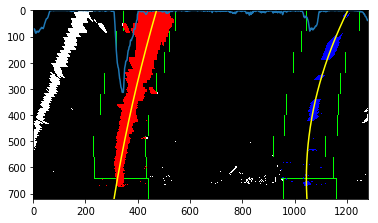

In [6]:
%matplotlib inline
# Try histogram sum
# Take a histogram of the bottom half of the image
print("warped im shape[0]:",warped_im.shape[0],"and shape[1]:",warped_im.shape[1])
histogram = np.sum(warped_im[int(warped_im.shape[0]/2):,:], axis=0)
plt.plot(histogram)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped_im, warped_im, warped_im))*255

# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
print("histogram shape[0]:",histogram.shape[0])# histogram has no shape[1]
leftx_base = np.argmax(histogram[:midpoint])
print("leftx base:",leftx_base)
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print("rightx base:",rightx_base)

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped_im.shape[0]/nwindows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped_im.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base

# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = warped_im.shape[0] - (window+1)*window_height
    win_y_high = warped_im.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 



# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, warped_im.shape[0]-1, warped_im.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

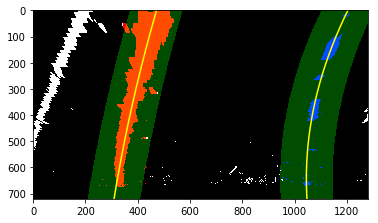

In [7]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped_im, warped_im, warped_im))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [8]:

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48


5938.83855903 1313.02648037


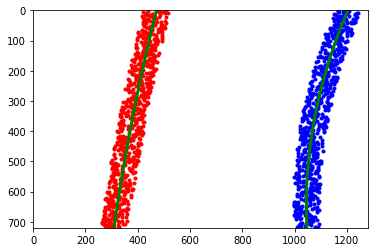

In [9]:
# Generate some fake data to represent lane-line pixels
#ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([y + np.random.randint(-50, high=51) 
                              for y in left_fitx])
rightx = np.array([y + np.random.randint(-50, high=51) 
                                for y in right_fitx])

#leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
#rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [10]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

#print("ploty shape:",ploty.shape[0])
#print("leftx shape:",leftx.shape[0])

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m


1877.07851868 m 429.153386956 m


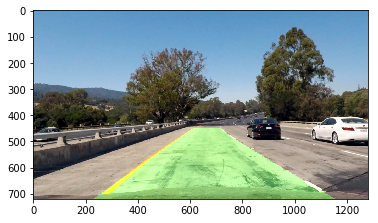

In [11]:
undist = cv2.undistort(image, mtx, dist, None, mtx)
#Four source coordinates
src = np.float32([[710,450],[1135,655],[110,655],[560,450]])
    
#Four desired coordinates
dst = np.float32([[1135,20],[1135,655],[110,655],[110,20]])
    
#Compute the perspective transform, M
M = cv2.getPerspectiveTransform(src,dst)
    
#Could compute the inverse M
Iver_M = cv2.getPerspectiveTransform(dst,src)


# Create an image to draw the lines on
warp_zero = np.zeros_like(warped_im).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Iver_M, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)

Now Test all images in the test_images folder

In [12]:
import os
files=os.listdir("test_images/")
binary_combo_list=[]
image_list=[]
for v in files:
    image = mpimg.imread('test_images/'+v)
    image_list.append(image)
    binary = pipeline(image)
    plt.figure()
    binary_combo_list.append(binary)

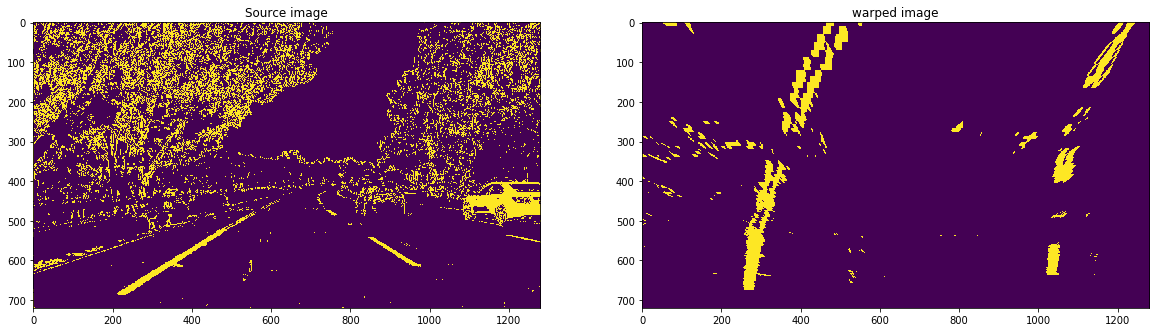

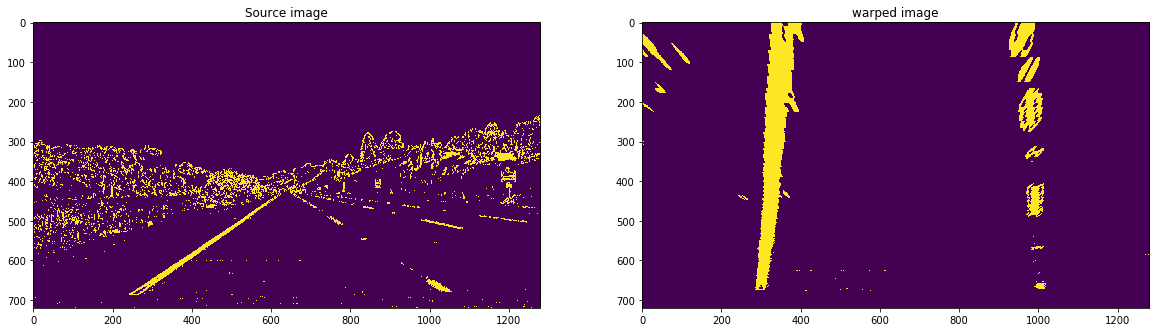

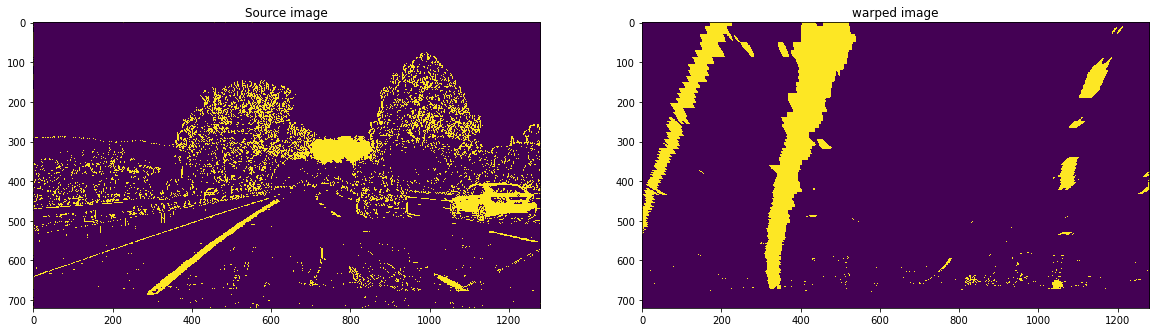

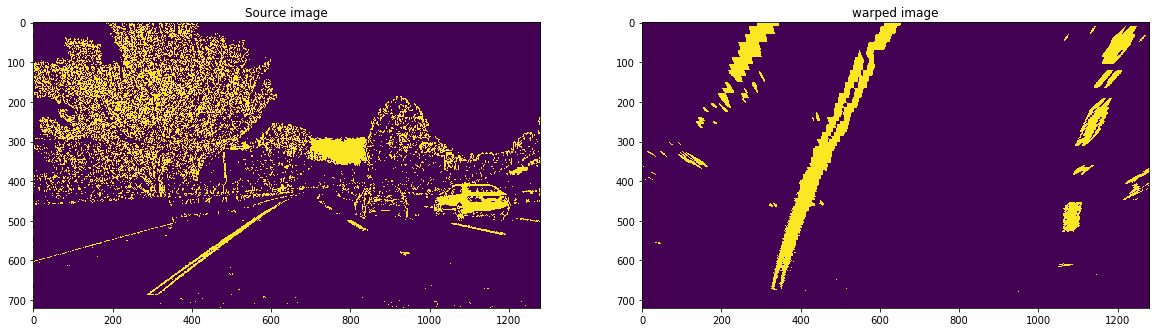

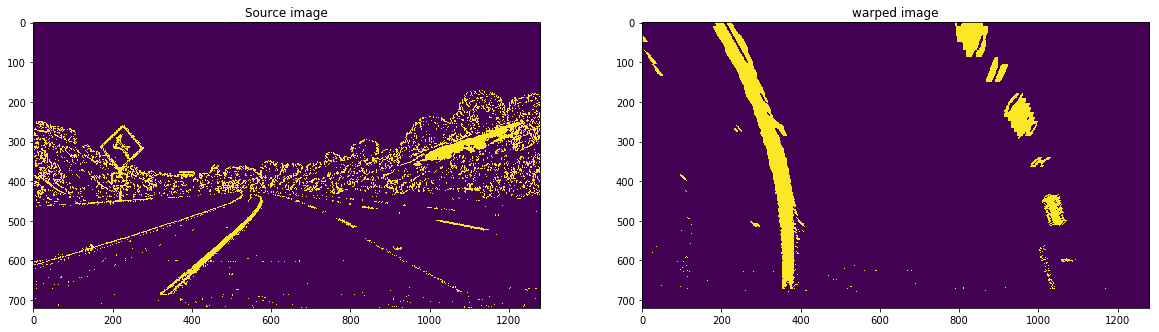

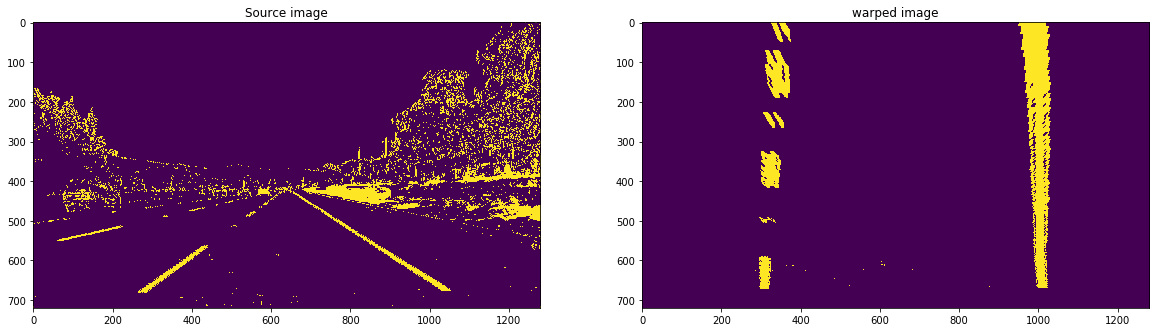

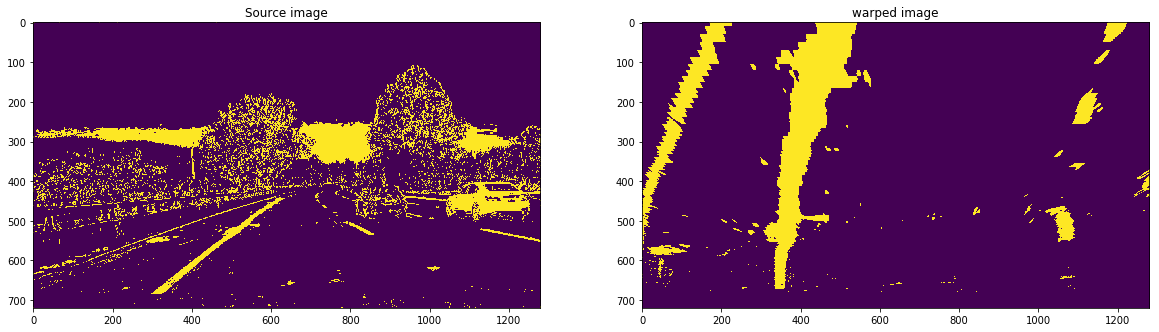

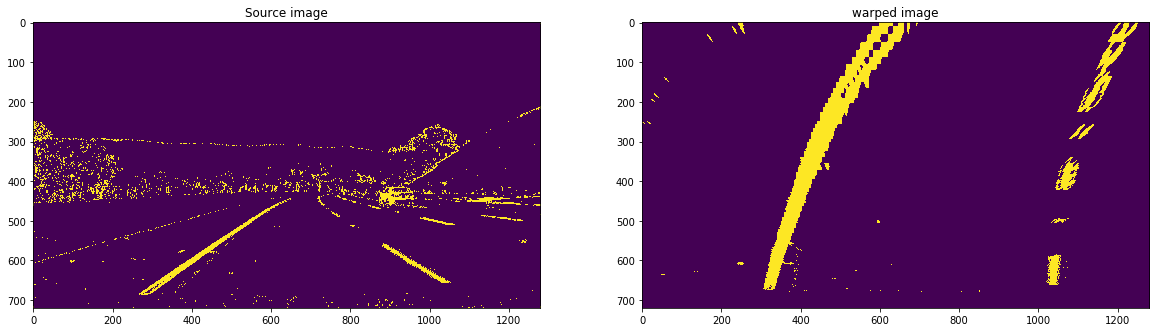

In [13]:
# color fit lines
warped_list=[]
for v in binary_combo_list:
    warped_im = warp(v)
    #VIsualize undistortion
    f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))

    ax1.set_title("Source image")
    ax1.imshow(v)
    ax2.set_title('warped image')
    ax2.imshow(warped_im)
    warped_list.append(warped_im)

In [14]:
# define color fit lines function
color_fit_lines_list=[]
left_fit_list=[]
right_fit_list=[]
def color_fit_lines(img):
    # Try histogram sum
    # Take a histogram of the bottom half of the image
    #print("warped im shape[0]:",warped_im.shape[0],"and shape[1]:",warped_im.shape[1])
    histogram = np.sum(img[int(img.shape[0]/2):,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((img, img, img))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    #print("histogram shape[0]:",histogram.shape[0])# histogram has no shape[1]
    leftx_base = np.argmax(histogram[:midpoint])
    #print("leftx base:",leftx_base)
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #print("rightx base:",rightx_base)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 



    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit_list.append(left_fit)
    right_fit_list.append(right_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_im.shape[0]-1, warped_im.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return out_img,left_fitx,right_fitx

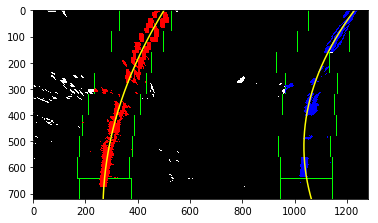

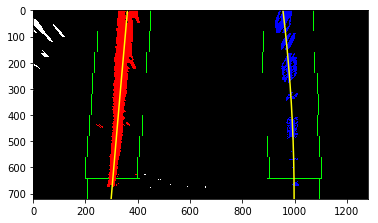

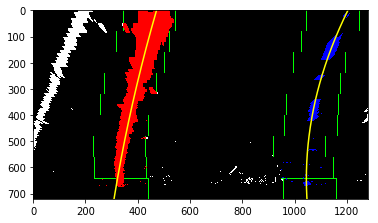

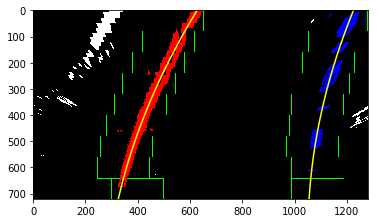

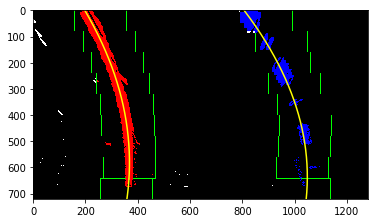

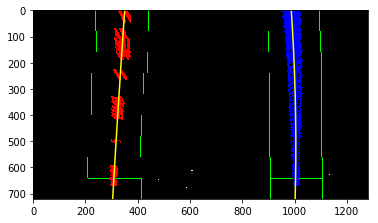

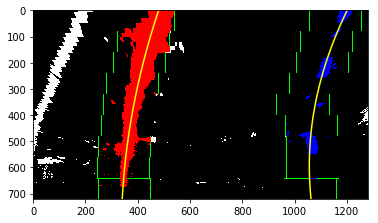

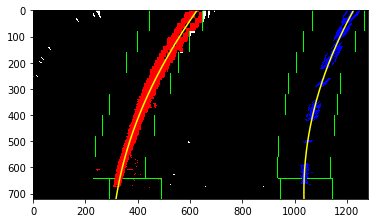

In [15]:
color_fit_lines_list=[]
left_fitx_list=[]
right_fitx_list=[]
for v in warped_list:
    color_fit_line,left_fitx,right_fitx = color_fit_lines(v)
    #VIsualize undistortion
    plt.imshow(color_fit_line)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    color_fit_lines_list.append(color_fit_line)
    left_fitx_list.append(left_fitx)
    right_fitx_list.append(right_fitx)



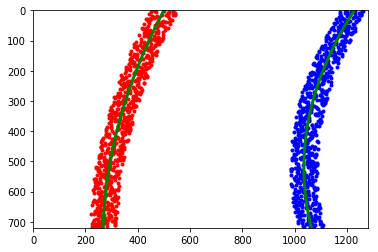

1251.42501545 788.606028462
410.293957147 m 231.273631791 m


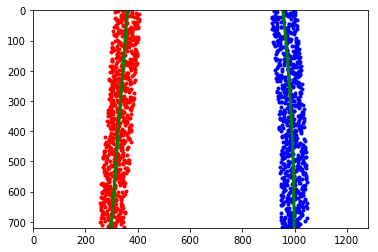

121646.291877 5939.34542176
39545.9151682 m 1950.7926348 m


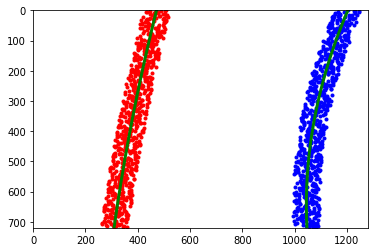

5938.83855903 1313.02648037
1877.07851868 m 429.153386956 m


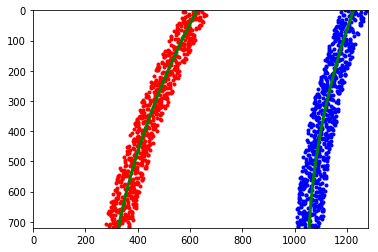

2068.87202085 2102.73003021
629.791653773 m 686.549902907 m


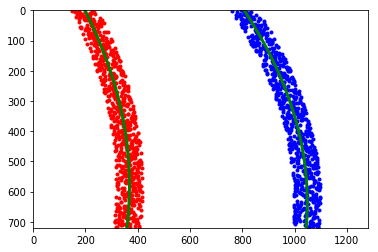

1020.80429752 850.083232119
326.018783065 m 275.196756076 m


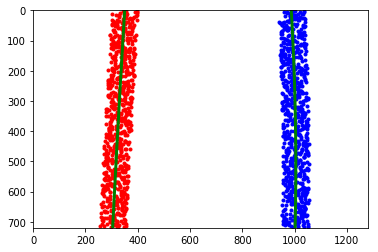

58682.5014224 7725.72638255
19180.4719351 m 2534.99453944 m


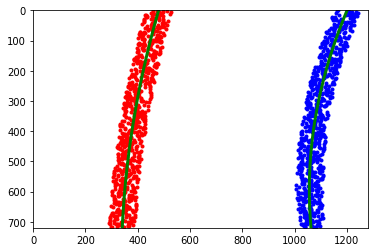

2589.25417489 1240.90862433
846.848778378 m 401.353492081 m


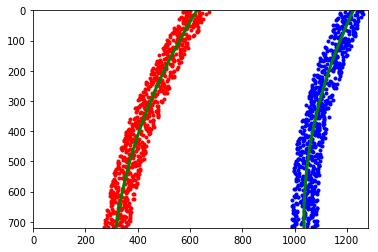

1358.29060835 1267.75051807
430.64823827 m 416.132092265 m


In [16]:

for y,v,x,z in zip(left_fitx_list,right_fitx_list,left_fit_list,right_fit_list):
    #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case 
    leftx = np.array([w + np.random.randint(-50, high=51) 
                                  for w in y])
    rightx = np.array([w + np.random.randint(-50, high=51) 
                                    for w in v])


    mark_size = 3
    plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
    plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(y, ploty, color='green', linewidth=3)
    plt.plot(v, ploty, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images
    plt.show()
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*x[0]*y_eval + x[1])**2)**1.5) / np.absolute(2*x[0])
    right_curverad = ((1 + (2*z[0]*y_eval + z[1])**2)**1.5) / np.absolute(2*z[0])
    print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    #print("ploty shape:",ploty.shape[0])
    #print("leftx shape:",leftx.shape[0])

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, y*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, v*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m





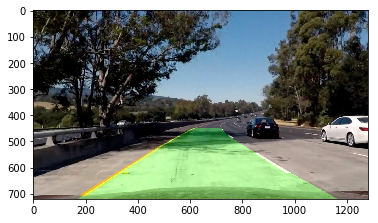

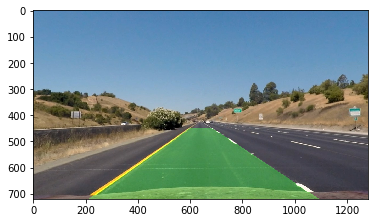

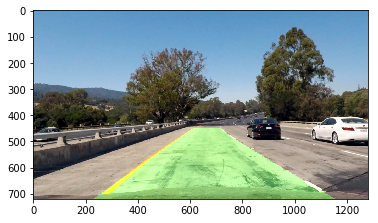

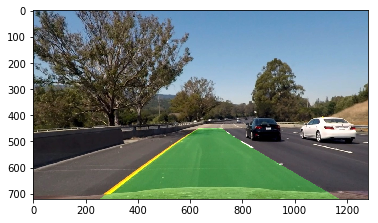

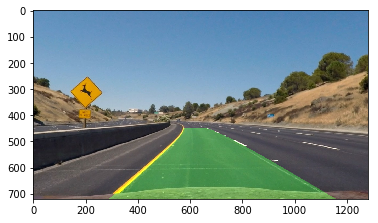

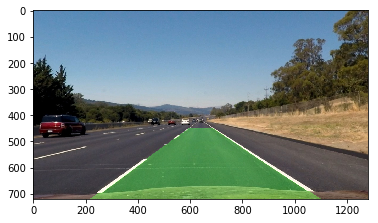

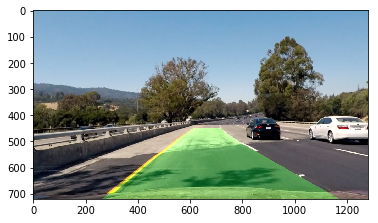

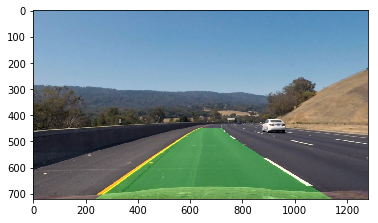

In [17]:
for a,b,y,v in zip(image_list,warped_list,left_fitx_list,right_fitx_list):
    
    
    undist = cv2.undistort(a, mtx, dist, None, mtx)
    #Four source coordinates
    src = np.float32([[710,450],[1135,655],[110,655],[560,450]])
    
    #Four desired coordinates
    dst = np.float32([[1135,20],[1135,655],[110,655],[110,20]])
    
    #Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src,dst)
    
    #Could compute the inverse M
    Iver_M = cv2.getPerspectiveTransform(dst,src)


    # Create an image to draw the lines on
    warp_zero = np.zeros_like(b).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([y, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([v, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    #Try to draw red dots and blue dots along lane lines
    #failed , think in the future
    
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Iver_M, (a.shape[1], a.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    plt.show()



In [18]:
def draw_lane(image,warped_im,left_fitx,right_fitx):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    #Four source coordinates
    src = np.float32([[710,450],[1135,655],[110,655],[560,450]])
    
    #Four desired coordinates
    dst = np.float32([[1135,20],[1135,655],[110,655],[110,20]])
    
    #Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src,dst)
    
    #Could compute the inverse M
    Iver_M = cv2.getPerspectiveTransform(dst,src)


    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_im).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    #Try to draw red dots and blue dots along lane lines
    #failed , think in the future
    
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Iver_M, (a.shape[1], a.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

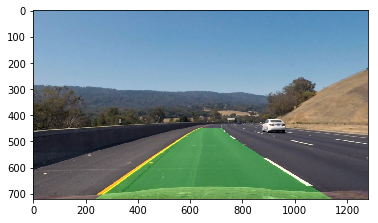

In [19]:
vvv=draw_lane(image,warped_im,left_fitx,right_fitx)
plt.imshow(vvv)
plt.show()

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    pipeline_result = pipeline(image)
    warped_im = warp(pipeline_result)
    color_fit_line,left_fitx,right_fitx = color_fit_lines(warped_im)
    result=draw_lane(image,warped_im,left_fitx,right_fitx)
    return result

In [ ]:
white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 52%|█████▏    | 659/1261 [02:52<02:39,  3.78it/s]